<a href="https://colab.research.google.com/github/avkornaev/Fast_AI_course/blob/main/XRayImagesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
#hide
!pip install -Uqq fastbook
#!git clone 'https://github.com/avkornaev/Fast_AI_course'
#!wget <ENTER URL> Download dataset from the web with

Connect to Google disk.

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries. Connect to Google disk.

In [75]:
import fastbook
#fastbook.setup_book() #an alternative to drive.mount with gdrive path instead of drive path 
import numpy as np
import pandas as pd
from fastbook import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *

Path.


In [76]:
dataPath = Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/')
imdsFolder = 'images'
#root_dir = dataPath
#base_dir = root_dir
#print(os.getcwd()) # current directory

In [77]:
print(os.getcwd()) # current directory

/content


Settings.

In [78]:
initImSize = 1024
reqImSize = 224
cropRatio = reqImSize/initImSize

Create list of classes.

In [79]:
classes = ['0 - Negative','1 - Typical','2 - Indeterminate','3 - Atypical']
n = len(classes)
print(os.getcwd()) # current directory
print(os.listdir('/content')) # and it's content

/content
['.config', 'drive', 'sample_data']


In [80]:
import json
with open(dataPath/"targets.json", "r") as f:
    targets = json.load(f)
#print(targets)

Check an image information.

In [81]:
image_id = '000a312787f2'
print('study level (class number): ', targets[image_id]['study_level'])
print('image level (bounding boxes): ', targets[image_id]['image_level'])
print('metadata (additional info from the DICOM image file): ', targets[image_id]['metadata'])

study level (class number):  1
image level (bounding boxes):  {'boxes': [[0.18545309210526317, 0.16698117832568807, 0.42667880169172934, 0.7166666485091744], [0.5277049060150376, 0.16949692660550458, 0.7849092340225564, 0.6745283027522936]], 'labels': [1, 1], 'image_id': '000a312787f2', 'iscrowd': [0, 0], 'area': [6653.2506748157, 6517.674527234884]}
metadata (additional info from the DICOM image file):  [0.1976, 0.35119999999999996, 0.5, -0.44066666666666665, -0.16366666666666668, 0.5, 0.0, 0.0, -0.75, -0.5, -0.5, -0.4166666666666667]


Create data frame.

In [82]:
targetsDFa = pd.DataFrame(targets) # auxiliary dataFrame
targetsDF = np.array([list(targetsDFa.columns+'.png'), list(targetsDFa.loc['study_level'].values)])
targetsDF = pd.DataFrame(targetsDF.T, columns = ['file_name', 'label'])

In [83]:
targetsDF.head()

,file_name,label
0,65761e66de9f.png,1
1,51759b5579bc.png,3
2,f6293b1c49e2.png,0
3,3019399c31f4.png,0
4,bb4b1da810f3.png,3


In [84]:
targetsDF.values.shape

(6331, 2)

Download and import of X-ray images.

https://docs.fast.ai/tutorial.medical_imaging.html#Download-and-import-of-X-ray-DICOM-files

https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_df

https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb#scrollTo=vP4nen7N383Q

In [85]:
?DataBlock

In [86]:
#images_source = untar_data()
# xray = ImageDataLoaders.from_df(targetsDF, path=dataPath/imdsFolder, valid_pct=0.2,
#                                 seed=42, fn_col=0, folder=None, 
#                                 suff='', label_col=1, label_delim=None, 
#                                 y_block=None, valid_col=None, item_tfms=Resize(224), 
#                                 batch_tfms=None, bs=64, val_bs=None, 
#                                 shuffle=None, device=None)
# item_tfms=Resize(128)

xray = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=lambda x: dataPath/imdsFolder/x[0],
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda x: x[1],
    item_tfms=RandomCrop(reqImSize))

In [87]:
#ColReader(targetsDF['file_name'])
#ColReader(targetsDF['label'])

In [88]:
dls = xray.dataloaders(targetsDF.values, path=dataPath/imdsFolder, num_workers=0, verbose=True)

 ['51759b5579bc.png' '3']
 ['f6293b1c49e2.png' '0']
 ...
 ['7d27b1bb3987.png' '1']
 ['52478e480a15.png' '1']
 ['8a80cfa63a23.png' '1']]
Found 6331 items
2 datasets of sizes 5065,1266
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: RandomCrop -- {'size': (224, 224), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}


Check images (optional).

In [89]:
#hide
fns = get_image_files(dataPath/imdsFolder)
fns
#failed = verify_images(fns)
#print(failed)
#failed.map(Path.unlink);

(#6331) [Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/images/f6293b1c49e2.png'),Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/images/d5ca04484172.png'),Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/images/ee33ec236561.png'),Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/images/03cafeb389a1.png'),Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/images/9c0c6581bc36.png'),Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/images/5c7b5fe49437.png'),Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/images/89fc91cc28bb.png'),Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/images/f82f99deaae2.png'),Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/images/657cadad1932.png'),Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/images/e885aaec6e66.png')...]

Visualise a batch of images.

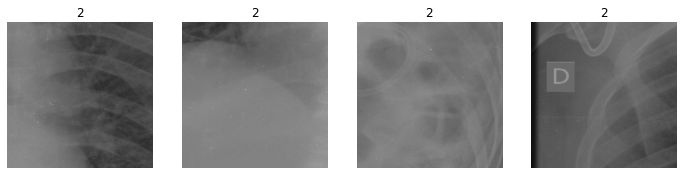

In [91]:
#dls = xray.dataloaders(targetsDF.values, num_workers=0)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Crop and augment images.

In [93]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,2.089231,1.486822,0.575040,51:04


epoch,train_loss,valid_loss,error_rate,time
0,1.593325,1.474545,0.511848,18:07


epoch,train_loss,valid_loss,error_rate,time
0,1.593325,1.474545,0.511848,18:07
1,1.464827,1.162893,0.465245,17:59


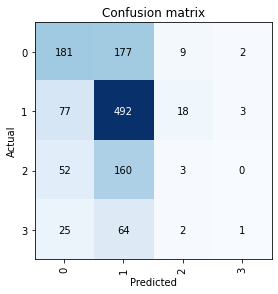

In [94]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Check top losses.

In [1]:
interp.plot_top_losses(8, nrows=2)

NameError: ignored

In [ ]:
#xray = xray.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
#xray.show_batch(max_n=4, nrows=1, unique=True)

In [96]:
learn.export()

PicklingError: ignored

References

[1] https://docs.fast.ai/tutorial.medical_imaging.html#Download-and-import-of-X-ray-DICOM-files